# Fit and predict using pib features and logistic regression

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from sklearn import preprocessing
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.feature_selection import SelectKBest
%matplotlib inline
plt.style.use('seaborn-notebook')

## Load data 

In [10]:
files_df = pd.read_pickle('../processed_data/files_df_mean_pib.pkl')
files_df.head()

,dir_name,file_name,path,patient,preictal,train,file_id,pib_0,pib_1,pib_2,pib_3,pib_4,pib_5,pib_6
0,test_1,1_1.mat,test_1/1_1.mat,1,-1,0,0,0.0870125,0.148382,0.0865826,0.0352896,0.0140147,0.00566536,0.00237758
1,test_1,1_10.mat,test_1/1_10.mat,1,-1,0,1,0.063977,0.0664608,0.0417149,0.0209176,0.00903446,0.00252979,0.000989945
2,test_1,1_100.mat,test_1/1_100.mat,1,-1,0,2,0.0709713,0.0849516,0.0540641,0.0274327,0.0121224,0.00349053,0.00142651
3,test_1,1_1000.mat,test_1/1_1000.mat,1,-1,0,3,0.0622139,0.0757878,0.047305,0.0226988,0.00971447,0.00269937,0.00105272
4,test_1,1_1001.mat,test_1/1_1001.mat,1,-1,0,4,0.0588816,0.0469657,0.0312127,0.0159075,0.00730864,0.00202842,0.000777936


## Extract useful data

In [11]:
meta_df = files_df.set_index('file_name')
meta_df = meta_df.loc[:,'patient':]
meta_df.head()

,patient,preictal,train,file_id,pib_0,pib_1,pib_2,pib_3,pib_4,pib_5,pib_6
file_name,,,,,,,,,,,
1_1.mat,1,-1,0,0,0.0870125,0.148382,0.0865826,0.0352896,0.0140147,0.00566536,0.00237758
1_10.mat,1,-1,0,1,0.063977,0.0664608,0.0417149,0.0209176,0.00903446,0.00252979,0.000989945
1_100.mat,1,-1,0,2,0.0709713,0.0849516,0.0540641,0.0274327,0.0121224,0.00349053,0.00142651
1_1000.mat,1,-1,0,3,0.0622139,0.0757878,0.047305,0.0226988,0.00971447,0.00269937,0.00105272
1_1001.mat,1,-1,0,4,0.0588816,0.0469657,0.0312127,0.0159075,0.00730864,0.00202842,0.000777936


In [34]:
# Train data
X_train = meta_df[meta_df['train']==1]
y_train = meta_df[meta_df['train']==1]['preictal']
X_train = X_train.drop(['train','preictal', 'file_id'], axis=1)
display(X_train.head())
display(y_train.head())

,patient,pib_0,pib_1,pib_2,pib_3,pib_4,pib_5,pib_6
file_name,,,,,,,,
1_1000_0.mat,1,0.10163,0.146955,0.0802858,0.0369979,0.0143574,0.00495526,0.00223435
1_1001_0.mat,1,0.106711,0.140512,0.078225,0.0348881,0.0141681,0.00521453,0.00234926
1_1002_0.mat,1,0.0864493,0.143632,0.0655083,0.0298233,0.0115557,0.00388654,0.00190574
1_1003_0.mat,1,0.0828803,0.150424,0.0797087,0.0377671,0.0155218,0.00474332,0.00232658
1_1004_0.mat,1,0.0614222,0.121627,0.0640707,0.0291021,0.0126332,0.00420025,0.00201733


file_name
1_1000_0.mat    0
1_1001_0.mat    0
1_1002_0.mat    0
1_1003_0.mat    0
1_1004_0.mat    0
Name: preictal, dtype: object

In [37]:
# Test data
X_test = meta_df[meta_df['train']==0]
X_test = X_test.drop(['train','preictal','file_id'], axis=1)
display(X_test.head())

,patient,pib_0,pib_1,pib_2,pib_3,pib_4,pib_5,pib_6
file_name,,,,,,,,
1_1.mat,1,0.0870125,0.148382,0.0865826,0.0352896,0.0140147,0.00566536,0.00237758
1_10.mat,1,0.063977,0.0664608,0.0417149,0.0209176,0.00903446,0.00252979,0.000989945
1_100.mat,1,0.0709713,0.0849516,0.0540641,0.0274327,0.0121224,0.00349053,0.00142651
1_1000.mat,1,0.0622139,0.0757878,0.047305,0.0226988,0.00971447,0.00269937,0.00105272
1_1001.mat,1,0.0588816,0.0469657,0.0312127,0.0159075,0.00730864,0.00202842,0.000777936


## Define pipeline and cross validation model fitting

In [38]:
param_grid = {
    'classify__loss': ['log'],
    'classify__penalty': ['elasticnet'],
    'classify__alpha': [10 ** x for x in range(-3, 1)],
    'classify__l1_ratio': [0, 0.2, 0.8, 1],
}

pipeline = Pipeline(steps=[
    ('imputer', Imputer()),    
    ('standardize', StandardScaler()),
    ('classify', SGDClassifier())
])

cv_pipeline =  GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='roc_auc')

In [45]:
display(X_train.head())
y_train = np.array(y_train).astype(int)
display(y_train[0:5])

,patient,pib_0,pib_1,pib_2,pib_3,pib_4,pib_5,pib_6
file_name,,,,,,,,
1_1000_0.mat,1,0.10163,0.146955,0.0802858,0.0369979,0.0143574,0.00495526,0.00223435
1_1001_0.mat,1,0.106711,0.140512,0.078225,0.0348881,0.0141681,0.00521453,0.00234926
1_1002_0.mat,1,0.0864493,0.143632,0.0655083,0.0298233,0.0115557,0.00388654,0.00190574
1_1003_0.mat,1,0.0828803,0.150424,0.0797087,0.0377671,0.0155218,0.00474332,0.00232658
1_1004_0.mat,1,0.0614222,0.121627,0.0640707,0.0291021,0.0126332,0.00420025,0.00201733


array([0, 0, 0, 0, 0])

In [46]:
%%time
cv_pipeline.fit(X=X_train, y=y_train)

CPU times: user 2.38 s, sys: 40.6 ms, total: 2.42 s
Wall time: 1.43 s


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('imputer', Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classify', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit...  penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'classify__alpha': [0.001, 0.01, 0.1, 1], 'classify__l1_ratio': [0, 0.2, 0.8, 1], 'classify__loss': ['log'], 'classify__penalty': ['elasticnet']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [47]:
print('{:.3%}'.format(cv_pipeline.best_score_))
print(cv_pipeline.best_params_)

65.865%
{'classify__alpha': 0.01, 'classify__l1_ratio': 1, 'classify__loss': 'log', 'classify__penalty': 'elasticnet'}


In [48]:
cv_result_df = pd.concat([
    pd.DataFrame(cv_pipeline.cv_results_),
    pd.DataFrame.from_records(cv_pipeline.cv_results_['params']),
], axis='columns')
cv_result_df.head(2)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classify__alpha,param_classify__l1_ratio,param_classify__loss,param_classify__penalty,params,rank_test_score,...,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score,classify__alpha,classify__l1_ratio,classify__loss,classify__penalty
0,0.067561,0.023183,0.491332,0.665794,0.001,0,log,elasticnet,"{'classify__alpha': 0.001, 'classify__l1_ratio...",16,...,0.654088,0.673825,0.077330,0.029542,0.137224,0.010182,0.001,0.0,log,elasticnet
1,0.014860,0.003125,0.505568,0.659267,0.001,0.2,log,elasticnet,"{'classify__alpha': 0.001, 'classify__l1_ratio...",10,...,0.609038,0.655660,0.002895,0.000457,0.106095,0.031891,0.001,0.2,log,elasticnet


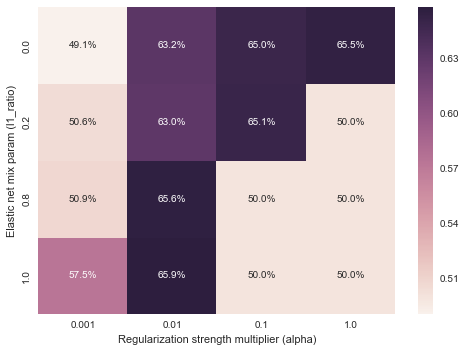

In [49]:
# Cross-validated performance heatmap
ax = plt.figure()
cv_score_mat = pd.pivot_table(cv_result_df, values='mean_test_score', index='classify__l1_ratio', columns='classify__alpha')

ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mix param (l1_ratio)');

## Use Optimal Hyperparameters to Output ROC Curve

In [50]:
def get_threshold_metrics(y_true, y_pred):
    roc_columns = ['fpr', 'tpr', 'threshold']
    roc_items = zip(roc_columns, roc_curve(y_true, y_pred))
    roc_df = pd.DataFrame.from_items(roc_items)
    auroc = roc_auc_score(y_true, y_pred)
    return {'auroc': auroc, 'roc_df': roc_df}

y_pred_train = cv_pipeline.decision_function(X_train)
metrics_train = get_threshold_metrics(y_train, y_pred_train)

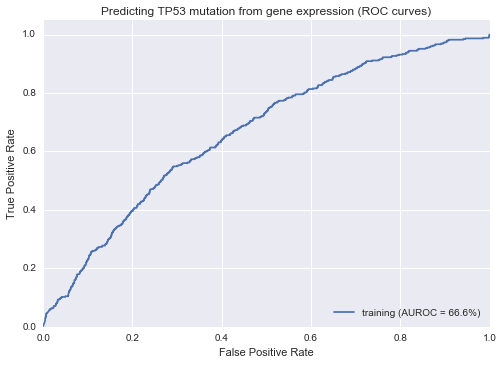

In [51]:
roc_df = metrics_train['roc_df']
plt.plot(roc_df.fpr, roc_df.tpr,
label='{} (AUROC = {:.1%})'.format('training', metrics_train['auroc']))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Predicting TP53 mutation from gene expression (ROC curves)')
plt.legend(loc='lower right');

## Predict test ictal status and save as csv

In [53]:
y_pred_test = cv_pipeline.predict(X_test)
output_df = pd.DataFrame({'File':X_test.index.values, 'Class': y_pred_test})
output_df = output_df[['File','Class']]
output_df.to_csv('../submissions/submission_6.csv',index=False)
output_df.head()

,File,Class
0,1_1.mat,0
1,1_10.mat,0
2,1_100.mat,0
3,1_1000.mat,0
4,1_1001.mat,0
